In [1]:
import math
import random
from graphviz import Digraph

import numpy as np
import matplotlib.pyplot as plt

import torch

%matplotlib inline

## Value object

In [2]:
class Value:
    def __init__(self, data, label='', op='', children=()):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self.label = label

    def __repr__(self):
        return f'Value({self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, children=(self, other), op='+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, children=(self, other), op='*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + (-other)
        
    def __neg__(self):
        return self * -1

    def __truediv__(self, other):
        return self * other**-1

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __pow__(self, exp):
        assert isinstance(exp, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**exp, children=(self,), op=f'**{exp}')

        def _backward():
            # power rule
            self.grad += exp * (self.data ** (exp-1)) * out.grad
        out._backward = _backward

        return out

    def  tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, children=(self,), op='tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), children=(self,), op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topsort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topsort(child)
                topo.append(v)
        topsort(self)

        # set grad to 1.0 or everything will be zero
        self.grad = 1.0
        # start at the current node
        for node in reversed(topo):
            node._backward()
    
    def dot(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
        
        # builds a set of all nodes and edges in a graph
        nodes, edges = set(), set()
        def build(v):
          if v not in nodes:
            nodes.add(v)
            for child in v._prev:
              edges.add((child, v))
              build(child)
        build(self)

        for n in nodes:
          uid = str(id(n))
          # for any value in the graph, create a rectangular ('record') node for it
          dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
          if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
        for n1, n2 in edges:
          # connect n1 to the op node of n2
          dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
        return dot

## Single tanh operatin

In [3]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

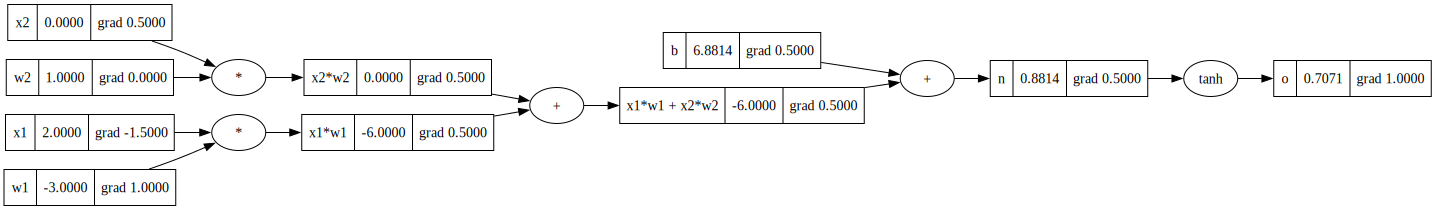

In [4]:
o.dot()

## Atomic tanh

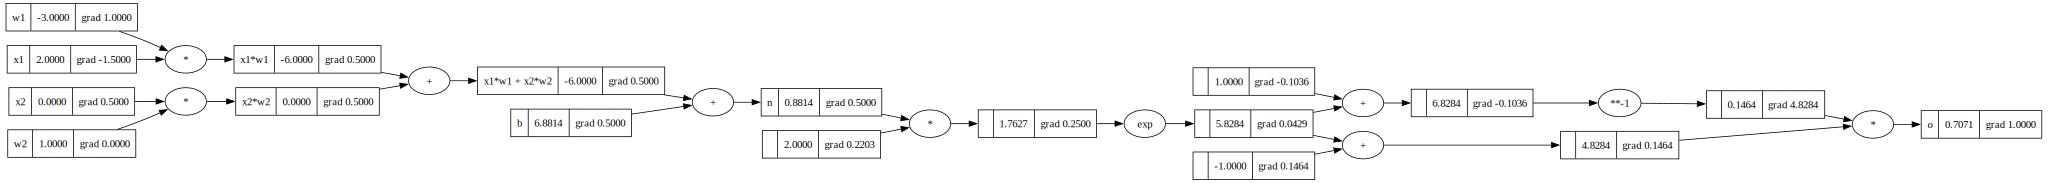

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'
o.backward()
o.dot()

## Example with Pytorch

In [6]:
# 1-element tensors, with gradient
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.data.item()

0.7071066904050358

In [7]:
o.backward()

In [8]:
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Neural network library

In [9]:
class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum([ww*xx for ww, xx in zip(self.w, x)], self.b)
        return activation.tanh()

    def parameters(self):
        return self.w + [self.b]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = .0

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def zero_grad(self):
        for n in self.neurons:
            n.zero_grad()

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def zero_grad(self):
        for l in self.layers:
            l.zero_grad()


## Binary classification example

In [10]:
x = [2., 3. -1.]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(-0.3445994963535462)

In [11]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

### Forward pass

To perform the forward pass, we calculate the loss function for of our neural network.

In [12]:
y_hats = [mlp(x) for x in xs]
y_hats

[Value(-0.36477175467709044),
 Value(-0.29512598846736426),
 Value(-0.02836826285160324),
 Value(-0.3000334831127297)]

In [13]:
# loss (RSS)
loss = sum([(y_hat - y)**2 for y, y_hat in zip(ys, y_hats)])
loss

Value(4.993604604346722)

We then do a backward pass (backpropagation) to evaluate the gradients.

In [14]:
# reset gradients
mlp.zero_grad()
# backward pass
loss.backward()

### Gradient descent

In [Gradient descent](http://en.wikipedia.org/wiki/Gradient_descent), we nudge the parameters against the direction of the gradient to minimize the loss function.

In [15]:
alpha = .01
for p in mlp.parameters():
    p.data += -alpha * p.grad

### Training loop

In [16]:
def rss(ys, y_hats):
    return sum([(y_hat - y)**2 for y, y_hat in zip(ys, y_hats)])

def train_mlp(mlp, Xs, ys, steps=10, alpha=.01):
    # forward pass
    y_hats = [mlp(x) for x in Xs]
    loss = rss(ys, y_hats)

    # print(f'0: {loss}')

    for k in range(steps):
        # reset gradients
        mlp.zero_grad()

        # backward pass
        loss.backward()

        # gradient descent update
        for p in mlp.parameters():
            p.data += -alpha * p.grad

        # forward pass
        y_hats = [mlp(x) for x in Xs]
        loss = rss(ys, y_hats)

        # print(f'{k+1}: {loss.data}') 
        print('.', end='')

    print('\n')
    print(f'final loss: {loss.data}')

In [17]:
train_mlp(mlp, xs, ys, steps=100, alpha=.1)

....................................................................................................

final loss: 0.0033834366040643325


In [18]:
[mlp(x) for x in xs]

[Value(0.9764773148180071),
 Value(-0.9807235663720343),
 Value(-0.965697331742816),
 Value(0.9641968445117277)]